In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np; np.random.seed(42)
import seaborn as sns

import pyLDAvis
import pyLDAvis.gensim
from collections import OrderedDict
from itertools import combinations
import MeCab
from konlpy.tag import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import normalize;
from sklearn import decomposition;

/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/gimjaewon/opt/anaconda3/envs/venv/l

In [2]:
df = pd.read_csv('adoor_data/answers.csv', encoding='UTF8')
df['created_at'] = pd.to_datetime(df['created_at'])

# df = df[(df.author_id != 5)]

start_date = pd.Timestamp(2019, 1, 28, 0)
end_date = pd.Timestamp(2019, 4, 1, 0)

mask = (df['created_at'] > start_date) & (df['created_at'] <= end_date)
df = df.loc[mask]

df.head()

,id,author_id,question_id,content,tag_string,created_at,updated_at
0,1,5,236,"오늘 상담쌤과 칭찬에 대한 대화를 나눴다. 내가 애들의 칭찬을 잘 못 믿는, 그리고...",NaN,2019-01-28 14:11:42.543635,2019-01-28 14:11:42.543635
1,2,5,103,원하는 순간에 생각의 흐름을 멈추고 하고자 하는 일에 집중할 수 있는 능력.,NaN,2019-01-28 14:12:09.623446,2019-01-28 14:12:09.623446
2,3,5,98,가만히 공상/유튜브. 혼자 있는 시간.,NaN,2019-01-28 14:13:16.547800,2019-01-28 14:13:16.547800
3,4,5,95,게으름. 그 중에서도 요즘 가장 싫은건 게으름으로 인해 더러워진 방. 너무 짜증나서...,NaN,2019-01-28 14:14:38.838070,2019-01-28 14:14:38.838070
4,6,4,5,진수니랑 같이 프론트 더 멋있게 만들기!!!!!\r\n,NaN,2019-01-28 15:55:14.088330,2019-01-28 15:55:14.088330


In [3]:
twitter = Okt()
pos = lambda d: ['/'.join(p) for p in twitter.pos(d, stem=True, norm=True)]

texts_ko = []
content = df.content
docs_ko = ""

for row in content:
    text = row
    if not pd.isna(text):
        docs_ko = docs_ko + text
        for morph in pos(text):
            if (morph.split('/')[1]) in ['Noun'] and len(morph.split('/')[0]) > 1:
                m = []
                m.append(morph)
                texts_ko.append(m)

In [4]:
dictionary_ko = corpora.Dictionary(texts_ko)
dictionary_ko.save('ko.dict')

In [5]:
tf_ko = [dictionary_ko.doc2bow(text) for text in texts_ko]
tfidf_model_ko = models.TfidfModel(tf_ko)
tfidf_ko = tfidf_model_ko[tf_ko]
corpora.MmCorpus.serialize('ko.mm', tfidf_ko)

In [6]:
ntopics, nwords = 5, 5

lda_ko = models.ldamodel.LdaModel(tf_ko, id2word=dictionary_ko, num_topics=ntopics)
lda_ko.print_topics()

[(0,
  '0.123*"사람/Noun" + 0.026*"지금/Noun" + 0.022*"인생/Noun" + 0.022*"가장/Noun" + 0.017*"항상/Noun" + 0.016*"기분/Noun" + 0.013*"보고/Noun" + 0.010*"어제/Noun" + 0.010*"이야기/Noun" + 0.010*"시작/Noun"'),
 (1,
  '0.019*"그냥/Noun" + 0.015*"자신/Noun" + 0.014*"감정/Noun" + 0.014*"욕망/Noun" + 0.012*"의지/Noun" + 0.012*"조금/Noun" + 0.011*"최근/Noun" + 0.011*"상담/Noun" + 0.009*"계속/Noun" + 0.009*"감성/Noun"'),
 (2,
  '0.121*"생각/Noun" + 0.033*"정말/Noun" + 0.027*"오늘/Noun" + 0.025*"친구/Noun" + 0.024*"하나/Noun" + 0.014*"대한/Noun" + 0.012*"수업/Noun" + 0.012*"노래/Noun" + 0.011*"수도/Noun" + 0.011*"누구/Noun"'),
 (3,
  '0.033*"마음/Noun" + 0.032*"기억/Noun" + 0.025*"때문/Noun" + 0.019*"요즘/Noun" + 0.017*"사실/Noun" + 0.015*"정도/Noun" + 0.015*"시간/Noun" + 0.014*"첫사랑/Noun" + 0.011*"표현/Noun" + 0.011*"세상/Noun"'),
 (4,
  '0.031*"진짜/Noun" + 0.017*"사랑/Noun" + 0.016*"손흥민/Noun" + 0.014*"다른/Noun" + 0.014*"질문/Noun" + 0.013*"이제/Noun" + 0.011*"얘기/Noun" + 0.011*"상처/Noun" + 0.011*"우리/Noun" + 0.010*"모습/Noun"')]

In [7]:
lda_ko = models.ldamodel.LdaModel(tfidf_ko, id2word=dictionary_ko, num_topics=ntopics)
lda_ko.print_topics()

[(0,
  '0.096*"생각/Noun" + 0.027*"정말/Noun" + 0.019*"하나/Noun" + 0.017*"손흥민/Noun" + 0.014*"자신/Noun" + 0.013*"정도/Noun" + 0.011*"조금/Noun" + 0.011*"의지/Noun" + 0.010*"모습/Noun" + 0.010*"표현/Noun"'),
 (1,
  '0.025*"때문/Noun" + 0.020*"그냥/Noun" + 0.014*"욕망/Noun" + 0.013*"이제/Noun" + 0.012*"상처/Noun" + 0.011*"우리/Noun" + 0.011*"의미/Noun" + 0.010*"이야기/Noun" + 0.010*"수도/Noun" + 0.010*"시작/Noun"'),
 (2,
  '0.034*"진짜/Noun" + 0.033*"기억/Noun" + 0.025*"친구/Noun" + 0.020*"사실/Noun" + 0.017*"기분/Noun" + 0.016*"다른/Noun" + 0.015*"시간/Noun" + 0.013*"첫사랑/Noun" + 0.013*"얘기/Noun" + 0.012*"최근/Noun"'),
 (3,
  '0.132*"사람/Noun" + 0.034*"마음/Noun" + 0.027*"지금/Noun" + 0.024*"가장/Noun" + 0.018*"항상/Noun" + 0.011*"어제/Noun" + 0.011*"경우/Noun" + 0.011*"계속/Noun" + 0.010*"아주/Noun" + 0.010*"현실/Noun"'),
 (4,
  '0.026*"오늘/Noun" + 0.023*"인생/Noun" + 0.020*"요즘/Noun" + 0.018*"사랑/Noun" + 0.016*"감정/Noun" + 0.015*"질문/Noun" + 0.013*"보고/Noun" + 0.013*"대한/Noun" + 0.012*"수업/Noun" + 0.011*"누구/Noun"')]

In [8]:
ldatopics = lda_ko.show_topics(formatted=False)
ldatopics[0]

(0,
 [('생각/Noun', 0.09571925),
  ('정말/Noun', 0.027276242),
  ('하나/Noun', 0.019301157),
  ('손흥민/Noun', 0.017088035),
  ('자신/Noun', 0.013667911),
  ('정도/Noun', 0.013032326),
  ('조금/Noun', 0.010754777),
  ('의지/Noun', 0.0106277205),
  ('모습/Noun', 0.009844296),
  ('표현/Noun', 0.009557482)])

In [9]:
lsi_ko = models.lsimodel.LsiModel(tfidf_ko, id2word=dictionary_ko, num_topics=ntopics)
lsi_ko.print_topics()

[(0,
  '-1.000*"사람/Noun" + -0.000*"대답/Noun" + -0.000*"느낌/Noun" + -0.000*"아마/Noun" + 0.000*"관계/Noun" + 0.000*"보통/Noun" + -0.000*"언제/Noun" + 0.000*"사고/Noun" + 0.000*"매우/Noun" + 0.000*"언니/Noun"'),
 (1,
  '-1.000*"생각/Noun" + 0.000*"아이/Noun" + -0.000*"영향/Noun" + -0.000*"능력/Noun" + -0.000*"먼저/Noun" + 0.000*"다음/Noun" + -0.000*"자주/Noun" + -0.000*"모습/Noun" + 0.000*"연락/Noun" + -0.000*"이유/Noun"'),
 (2,
  '1.000*"정말/Noun" + 0.005*"그게/Noun" + 0.004*"기대/Noun" + 0.004*"내일/Noun" + 0.004*"최악/Noun" + -0.004*"기도/Noun" + 0.004*"정리/Noun" + -0.003*"우리/Noun" + -0.003*"아마/Noun" + 0.003*"관계/Noun"'),
 (3,
  '-1.000*"지금/Noun" + 0.004*"우리/Noun" + -0.004*"가지/Noun" + 0.004*"음악/Noun" + -0.003*"학교/Noun" + -0.003*"현실/Noun" + 0.003*"영화/Noun" + -0.003*"존재/Noun" + -0.003*"여행/Noun" + -0.003*"그때/Noun"'),
 (4,
  '-1.000*"마음/Noun" + -0.005*"우리/Noun" + 0.005*"자기/Noun" + -0.004*"자신감/Noun" + -0.004*"대부분/Noun" + -0.004*"최고/Noun" + -0.004*"스스로/Noun" + 0.004*"핸드폰/Noun" + -0.004*"가지/Noun" + 0.003*"그게/Noun"')]

In [10]:
hdp_ko = models.hdpmodel.HdpModel(tfidf_ko, id2word=dictionary_ko)
hdp_ko.print_topics(ntopics, nwords)

[(0,
  '0.003*지원이/Noun + 0.003*살걸/Noun + 0.003*관계대명사/Noun + 0.003*마늘/Noun + 0.002*무려/Noun'),
 (1,
  '0.003*원망/Noun + 0.003*레일/Noun + 0.003*바닷가/Noun + 0.002*포스터/Noun + 0.002*횟수/Noun'),
 (2,
  '0.005*바지/Noun + 0.004*명령/Noun + 0.003*야망/Noun + 0.003*게으름/Noun + 0.003*잭슨/Noun'),
 (3,
  '0.003*여름/Noun + 0.003*화장실/Noun + 0.003*보조/Noun + 0.003*서울대/Noun + 0.003*불닭/Noun'),
 (4,
  '0.003*자전거/Noun + 0.003*사용/Noun + 0.003*프사/Noun + 0.002*이익/Noun + 0.002*판본/Noun')]

In [11]:
bow = tfidf_model_ko[dictionary_ko.doc2bow(texts_ko[0])]
sorted(lda_ko[bow], key=lambda x: x[1], reverse=True)

[(4, 0.59999603),
 (2, 0.100001045),
 (3, 0.100001015),
 (0, 0.10000097),
 (1, 0.100000955)]

In [12]:
sorted(hdp_ko[bow], key=lambda x: x[1], reverse=True)

[(73, 0.503363302821386)]

In [13]:
bow = tfidf_model_ko[dictionary_ko.doc2bow(texts_ko[1])]
sorted(lda_ko[bow], key=lambda x: x[1], reverse=True)

[(2, 0.59999263),
 (3, 0.1000019),
 (4, 0.1000019),
 (1, 0.10000185),
 (0, 0.10000175)]

In [14]:
sorted(hdp_ko[bow], key=lambda x: x[1], reverse=True)

[(144, 0.5032959061234874)]

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=tf_ko, num_topics=num_topics, id2word=dictionary_ko)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts_ko, dictionary=dictionary_ko, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
coherence_model_lda = models.CoherenceModel(model=lda_ko, texts=texts_ko, dictionary=dictionary_ko, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8439501451857876


In [17]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary_ko, 
    corpus=tf_ko, 
    texts=texts_ko, 
    start=1, 
    limit=10, 
    step=1)

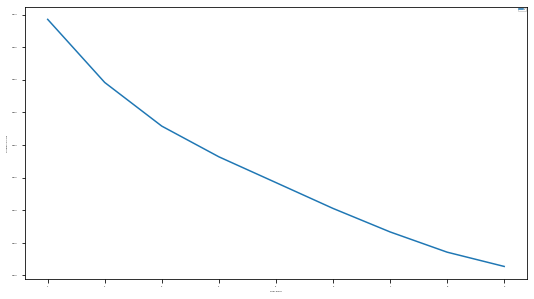

In [18]:
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.rcParams["font.size"] = 2
plt.figure(figsize=(9,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.8693
Num Topics = 2  has Coherence Value of 0.8596
Num Topics = 3  has Coherence Value of 0.8529
Num Topics = 4  has Coherence Value of 0.8482
Num Topics = 5  has Coherence Value of 0.8442
Num Topics = 6  has Coherence Value of 0.8403
Num Topics = 7  has Coherence Value of 0.8367
Num Topics = 8  has Coherence Value of 0.8336
Num Topics = 9  has Coherence Value of 0.8314


In [20]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.012*"진짜/Noun" + 0.012*"마음/Noun" + 0.012*"기억/Noun" + 0.010*"정말/Noun" + 0.009*"지금/Noun" + 0.009*"친구/Noun" + 0.008*"그냥/Noun" + 0.006*"항상/Noun" + 0.006*"사실/Noun" + 0.006*"정도/Noun"'),
 (1,
  '0.047*"사람/Noun" + 0.043*"생각/Noun" + 0.010*"오늘/Noun" + 0.010*"때문/Noun" + 0.009*"가장/Noun" + 0.009*"인생/Noun" + 0.009*"하나/Noun" + 0.007*"요즘/Noun" + 0.006*"기분/Noun" + 0.006*"자신/Noun"')]

In [21]:
def format_topics_sentences(ldamodel=lda_ko, corpus=tf_ko, texts=df['content'].values.astype('U')):
   
    sent_topics_df = pd.DataFrame()

   
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # -- dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tf_ko, texts=df['content'].values.astype('U'))


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7484,"사람/Noun, 생각/Noun, 오늘/Noun, 때문/Noun, 가장/Noun, 인...","오늘 상담쌤과 칭찬에 대한 대화를 나눴다. 내가 애들의 칭찬을 잘 못 믿는, 그리고..."
1,1,0.0,0.7484,"진짜/Noun, 마음/Noun, 기억/Noun, 정말/Noun, 지금/Noun, 친...",원하는 순간에 생각의 흐름을 멈추고 하고자 하는 일에 집중할 수 있는 능력.
2,2,0.0,0.7207,"진짜/Noun, 마음/Noun, 기억/Noun, 정말/Noun, 지금/Noun, 친...",가만히 공상/유튜브. 혼자 있는 시간.
3,3,1.0,0.7472,"사람/Noun, 생각/Noun, 오늘/Noun, 때문/Noun, 가장/Noun, 인...",게으름. 그 중에서도 요즘 가장 싫은건 게으름으로 인해 더러워진 방. 너무 짜증나서...
4,4,0.0,0.7456,"진짜/Noun, 마음/Noun, 기억/Noun, 정말/Noun, 지금/Noun, 친...",진수니랑 같이 프론트 더 멋있게 만들기!!!!!\r\n


In [22]:
path='/Library/Fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rc('axes', unicode_minus=False)
plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)

In [23]:
# Latent Dirichlet Allocation, LDA is yet another transformation from 
# bag-of-words counts into a topic space of lower dimensionality. 
# LDA is a probabilistic extension of LSA (also called multinomial PCA), 
# so LDA’s topics can be interpreted as probability distributions over words. 
# These distributions are, just like with LSA, inferred automatically from 
# a training corpus. Documents are in turn interpreted as a (soft) mixture 
# of these topics (again, just like with LSA)

In [24]:
data_lda = {i: OrderedDict(lda_ko.show_topic(i, 5)) for i in range(5)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)
df_lda

(5, 25)


,생각/Noun,정말/Noun,하나/Noun,손흥민/Noun,자신/Noun,때문/Noun,그냥/Noun,욕망/Noun,이제/Noun,상처/Noun,...,사람/Noun,마음/Noun,지금/Noun,가장/Noun,항상/Noun,오늘/Noun,인생/Noun,요즘/Noun,사랑/Noun,감정/Noun
0,0.095719,0.027276,0.019301,0.017088,0.013668,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.024553,0.020101,0.014489,0.013498,0.011892,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.131587,0.034009,0.027453,0.02412,0.01799,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.026181,0.023023,0.019923,0.018447,0.015889


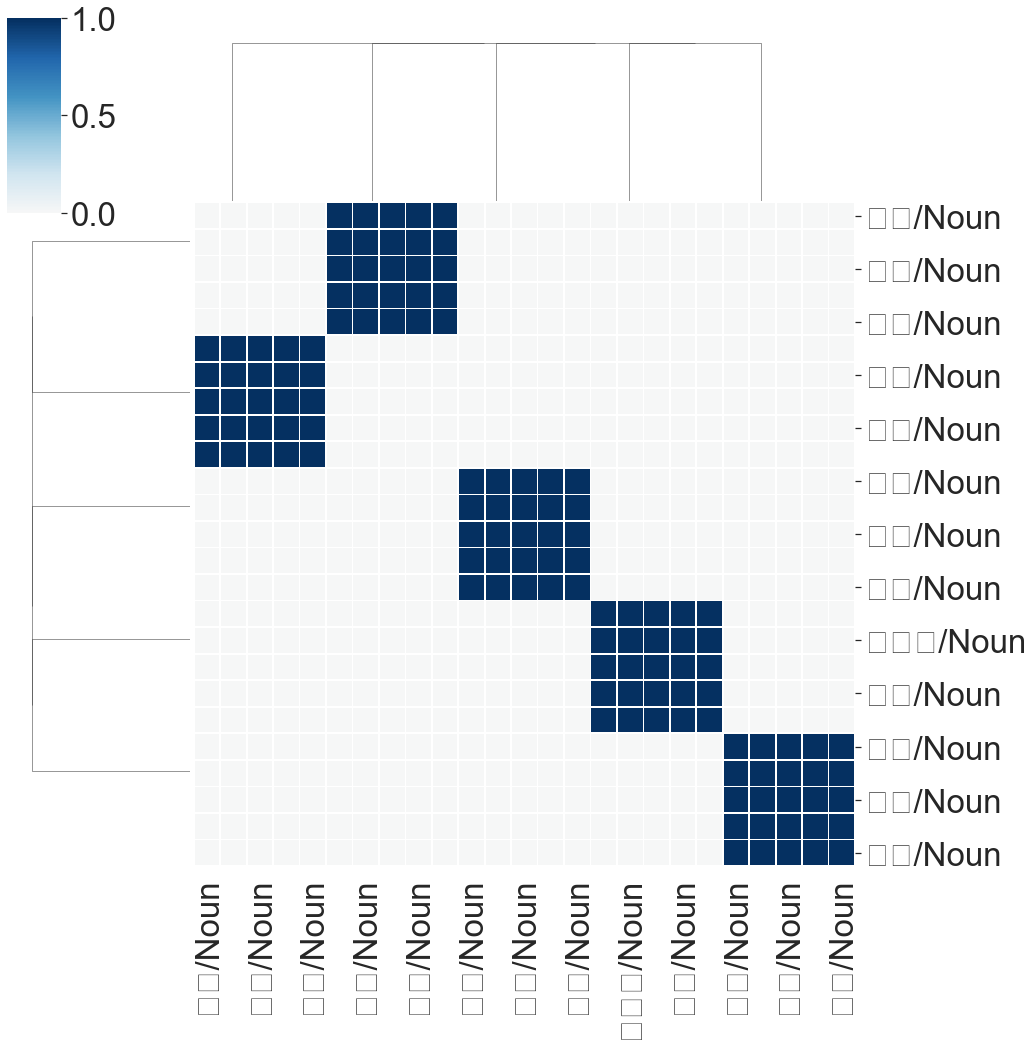

In [25]:
sns.set(font_scale=3)
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [26]:
corpus_lda = lda_ko[tfidf_ko]

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_ko, corpus_lda, dictionary_ko, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  29.407576
4       51.163364 -159.968018       2        1  29.175297
2      -73.144554   21.523815       3        1  21.376324
0      -66.410133 -110.606438       4        1  10.025386
1       54.417324   12.443444       5        1  10.015417, topic_info=          Term        Freq       Total Category  logprob  loglift
74     사람/Noun  280.000000  280.000000  Default  30.0000  30.0000
10     생각/Noun   75.000000   75.000000  Default  29.0000  29.0000
350    마음/Noun   73.000000   73.000000  Default  28.0000  28.0000
342    진짜/Noun   53.000000   53.000000  Default  27.0000  27.0000
277    기억/Noun   51.000000   51.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
511    아마/Noun    4.555101    5.540449   Topic5  -5.0681   2.1052
1522   건가/Noun    3.215436    3.928871   Topic5  -5.4164   2.1007
1319  무의식/Noun    3.215426    3.928882   Topic5  -5.4164   2.1006
107    어도/Noun    5.078575    6.469091   Topic5  -4.9593   2.0590
319    편지/Noun    3.414546    4.406595   Topic5  -5.3563   2.0460

[198 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
463       3  0.976457   가끔/Noun
20        1  0.983871   가장/Noun
126       4  0.697405   가족/Noun
1434      4  0.886281   감성/Noun
479       2  0.968527   감정/Noun
...     ...       ...       ...
16        2  0.946752   혼자/Noun
188       1  0.919655  화장실/Noun
2474      1  0.775670   휘민/Noun
2474      4  0.141031   휘민/Noun
1063      5  0.728021   휴학/Noun

[201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

In [27]:
def getNVM_lemma(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    word_tag = [w for w in parsed.split("\n")]
    pos = []
    tags = ['NNG','NNP','VV','VA', 'VX', 'VCP','VCN']
    for word_ in word_tag[:-2]:
        word = word_.split("\t")
        tag = word[1].split(",")
        if(len(word[0]) < 2) or ("게" in word[0]):
            continue
        if(tag[-1] != '*'):
            t = tag[-1].split('/')
            if(len(t[0]) > 1 and ('VV' in t[1] or 'VA' in t[1] or 'VX' in t[1])):
                pos.append(t[0])
        else:
            if(tag[0] in tags):
                pos.append(word[0])
    return pos

In [28]:
vectorizer = CountVectorizer(tokenizer=getNVM_lemma, min_df=2)
x_counts = vectorizer.fit_transform(df['content'].values.astype('U'))
print( "Created %d X %d document-term matrix" % (x_counts.shape[0], x_counts.shape[1]) )
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

Created 1005 X 845 document-term matrix


In [29]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 845 distinct terms


In [30]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
model = NMF(n_components=10, init='nndsvd');
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=10)

In [34]:
def get_nmf_topics(model, n_top_words):
    
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [35]:
num_topics = 5
nmf_df = get_nmf_topics(model, 5)
nmf_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,생각,사람,모르,친구,어렵
1,행동,보이,돌아오,남자,성격
2,괜찮,만나,대답,대화,변하
3,예전,자신,바꾸,그렇,평생
4,들어오,힘들,만드,만나,고민
5,평생,편하,부탁,노래,만들
6,정도,버리,구체,힘들,질문
7,보이,이야기,도어,기쁘,택하
8,머리,목표,알아주,진심,에어컨
9,멋지,좋아하,따르,친하,요소


In [36]:
num_topics = 10
nmf_df = get_nmf_topics(model, 5)
nmf_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,생각,사람,모르,친구,어렵,사랑,배우,시간,행복,학교
1,행동,보이,돌아오,남자,성격,엄마,재미,일어나,인생,파이
2,괜찮,만나,대답,대화,변하,원망,가르침,버스,아름답,형태
3,예전,자신,바꾸,그렇,평생,아니,가르치,자신,하당,공연
4,들어오,힘들,만드,만나,고민,신뢰,감사,지나,건강,연극
5,평생,편하,부탁,노래,만들,갔다오,반성,기대,아니,리스트
6,정도,버리,구체,힘들,질문,대신,악기,수업,미치,소원
7,보이,이야기,도어,기쁘,택하,재미,입학,오늘,평생,알차
8,머리,목표,알아주,진심,에어컨,능력,대학,돌아보,하루,피곤
9,멋지,좋아하,따르,친하,요소,마음,여유,통화,진심,만나
